# Cell 1 — Imports & paths

In [1]:
# Cell 1 — Setup + imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
ROOT = Path("..")  # notebook in notebooks/, raw file is ../data/raw/...
RAW_FILE = ROOT / "data" / "raw" / "MachineLearningRating_v3.txt"
PROCESSED_FILE = ROOT / "data" / "processed" / "insurance_cleaned.csv"

print("Notebook cwd:", Path.cwd())
print("Raw file expected at:", RAW_FILE)


Notebook cwd: d:\10acadamyWeek3 Project\insurance-risk-analytics-and-prediction\notebooks
Raw file expected at: ..\data\raw\MachineLearningRating_v3.txt


# Cell 2 — Load file (pipe-delimited), preview, quick cleaning of whitespace

In [2]:
# Cell 2 — Load pipe-delimited file
if not RAW_FILE.exists():
    raise FileNotFoundError(f"Cannot find raw file: {RAW_FILE}")

# read with pipe delimiter, keep default quoting
df = pd.read_csv(RAW_FILE, sep='|', dtype=str, low_memory=False)

# strip whitespace from column names and values
df.columns = [c.strip() for c in df.columns]
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

print("Loaded rows:", len(df))
display(df.head(5))


C:\Users\bethy\AppData\Local\Temp\ipykernel_15528\3533344544.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Loaded rows: 1000098


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929824561403,.000000000000
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929824561403,.000000000000
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,.000000000000,.000000000000
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070175439,.000000000000
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,.000000000000,.000000000000


# Cell 4 — Convert numeric columns (TotalPremium, TotalClaims) and date parsing

In [3]:
# Cell 4 — Convert numeric and date columns safely

# Numeric columns: remove commas and coerce to numeric (some rows may contain empty)
for col in ['TotalPremium','TotalClaims','CustomValueEstimate','SumInsured','CalculatedPremiumPerTerm']:
    if col in df.columns:
        # Replace commas, handle '.' decimal strings, coerce errors to NaN
        df[col] = df[col].str.replace(',', '').replace('', np.nan)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Parse date: TransactionMonth seems like 'YYYY-MM-DD HH:MM:SS'
if 'TransactionMonth' in df.columns:
    df['transaction_date'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
else:
    # attempt to find any column with 'date' in name
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'month' in c.lower()]
    if date_cols:
        df['transaction_date'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        df['transaction_date'] = pd.NaT

print("transaction_date range:", df['transaction_date'].min(), "to", df['transaction_date'].max())
display(df[['transaction_date','TotalPremium','TotalClaims']].head(5))


transaction_date range: 2013-10-01 00:00:00 to 2015-08-01 00:00:00


,transaction_date,TotalPremium,TotalClaims
0,2015-03-01,21.929825,0.0
1,2015-05-01,21.929825,0.0
2,2015-07-01,0.000000,0.0
3,2015-05-01,512.848070,0.0
4,2015-07-01,0.000000,0.0


# Cell 6 — Basic stats and missing values

In [5]:
# Cell 6 — Basic stats
num_cols = ['TotalPremium','TotalClaims','loss_ratio','margin']
num_present = [c for c in num_cols if c in df.columns]
display(df[num_present].describe().T)

print("\nMissing value percent (top 20):")
missing_pct = (df.isnull().mean() * 100).sort_values(ascending=False)
display(missing_pct.head(20))


,count,mean,std,min,25%,50%,75%,max
TotalPremium,1000098.0,61.905496,230.284513,-782.576754,0.0,2.178333,21.929825,65282.603421
TotalClaims,1000098.0,64.861190,2384.074695,-12002.412281,0.0,0.000000,0.000000,393092.105263
loss_ratio,618464.0,0.349885,9.286479,-18.700122,0.0,0.000000,0.000000,2553.600000
margin,1000098.0,-2.955694,2367.136547,-392848.566930,0.0,2.157687,21.929825,65282.603421



Missing value percent (top 20):


NumberOfVehiclesInFleet    100.000000
CrossBorder                 99.930207
CustomValueEstimate         77.956560
Rebuilt                     64.183810
Converted                   64.183810
WrittenOff                  64.183810
loss_ratio                  38.159660
NewVehicle                  15.327998
Bank                        14.594670
AccountType                  4.022806
Gender                       0.953507
MaritalStatus                0.825819
NumberOfDoors                0.055195
VehicleIntroDate             0.055195
bodytype                     0.055195
kilowatts                    0.055195
Cylinders                    0.055195
mmcode                       0.055195
Model                        0.055195
cubiccapacity                0.055195
dtype: float64

# cell 7-  basic info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 56 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   UnderwrittenCoverID       1000098 non-null  object        
 1   PolicyID                  1000098 non-null  object        
 2   TransactionMonth          1000098 non-null  object        
 3   IsVATRegistered           1000098 non-null  object        
 4   Citizenship               1000098 non-null  object        
 5   LegalType                 1000098 non-null  object        
 6   Title                     1000098 non-null  object        
 7   Language                  1000098 non-null  object        
 8   Bank                      854137 non-null   object        
 9   AccountType               959866 non-null   object        
 10  MaritalStatus             991839 non-null   object        
 11  Gender                    990562 non-null   object

# cell 8-  handle missing value 

In [7]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

# Check for spaces/empty strings (like in Citizenship)
empty_strings = {}
for col in df.columns:
    if df[col].dtype == 'object':  # Text columns
        empty_count = (df[col] == ' ').sum() + (df[col] == '').sum()
        if empty_count > 0:
            empty_strings[col] = empty_count

print("Empty strings/spaces:\n", empty_strings)

# Replace empty strings with NaN
df = df.replace([' ', ''], np.nan)

Missing values:
 Bank                        145961
AccountType                  40232
MaritalStatus                 8259
Gender                        9536
mmcode                         552
VehicleType                    552
make                           552
Model                          552
Cylinders                      552
cubiccapacity                  552
kilowatts                      552
bodytype                       552
NumberOfDoors                  552
VehicleIntroDate               552
CustomValueEstimate         779642
CapitalOutstanding               2
NewVehicle                  153295
WrittenOff                  641901
Rebuilt                     641901
Converted                   641901
CrossBorder                 999400
NumberOfVehiclesInFleet    1000098
loss_ratio                  381634
dtype: int64
Empty strings/spaces:
 {'Citizenship': np.int64(895210)}


# cell 9- Handle Specific Column Issues

In [8]:
# Fix Gender column (has "Not specified")
df['Gender'] = df['Gender'].replace('Not specified', np.nan)

# Fix MaritalStatus
df['MaritalStatus'] = df['MaritalStatus'].replace('Not specified', np.nan)

# Fix Yes/No columns
yes_no_cols = ['IsVATRegistered', 'AlarmImmobiliser', 'TrackingDevice', 
               'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder']

for col in yes_no_cols:
    if col in df.columns:
        # Convert to boolean where possible
        df[col] = df[col].map({'Yes': True, 'No': False, True: True, False: False})
        # Fill remaining with mode if few missing
        if df[col].isnull().sum() < len(df) * 0.1:  # Less than 10% missing
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else False)

# Cell 10 — Create KPIs: has_claim, loss_ratio, margin

In [ ]:
# Cell 10 — KPIs
df['has_claim'] = (df['TotalClaims'].fillna(0) > 0).astype(int)

# loss_ratio = TotalClaims / TotalPremium, guard divide by zero/NaN
def safe_loss_ratio(row):
    tp = row['TotalPremium']
    tc = row['TotalClaims']
    if pd.isna(tp) or tp == 0:
        return np.nan
    return tc / tp

df['loss_ratio'] = df.apply(safe_loss_ratio, axis=1)
df['margin'] = df['TotalPremium'] - df['TotalClaims']

display(df[['TotalPremium','TotalClaims','has_claim','loss_ratio','margin']].head(6))


,TotalPremium,TotalClaims,has_claim,loss_ratio,margin
0,21.929825,0.0,0,0.0,21.929825
1,21.929825,0.0,0,0.0,21.929825
2,0.000000,0.0,0,NaN,0.000000
3,512.848070,0.0,0,0.0,512.848070
4,0.000000,0.0,0,NaN,0.000000
5,3.256435,0.0,0,0.0,3.256435


# cell 11 - handle outliers

In [11]:
# Function to cap outliers
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower = series.quantile(lower_percentile/100)
    upper = series.quantile(upper_percentile/100)
    return series.clip(lower, upper)

# Cap outliers in key financial columns
financial_cols = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'SumInsured']
for col in financial_cols:
    if col in df.columns and df[col].notnull().sum() > 0:
        df[f'{col}_Capped'] = cap_outliers(df[col])

# cell 12 - Plot 1: Monthly trend (TotalPremium vs TotalClaims)

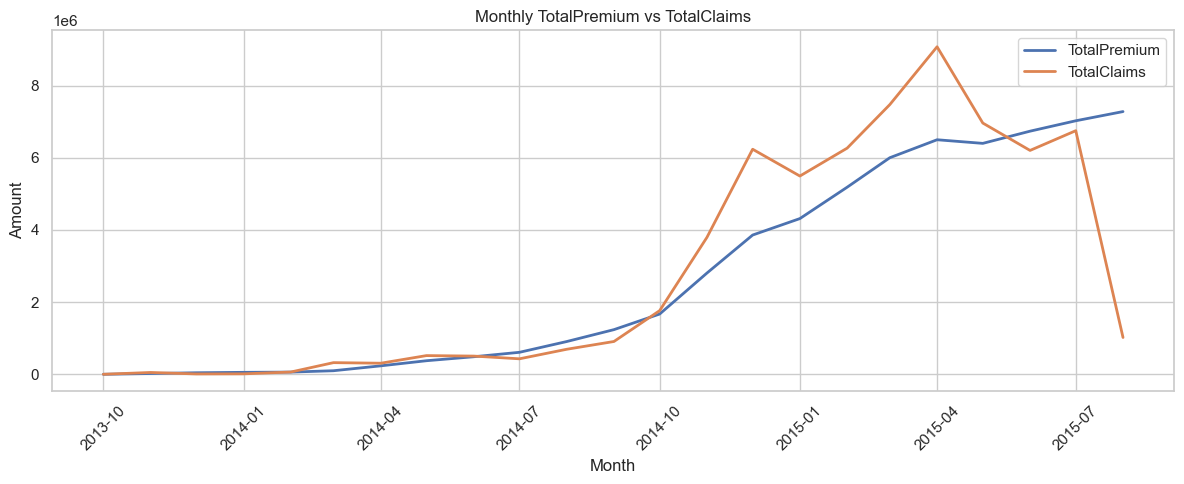

In [ ]:
# Cell 12 — Monthly trend plot
if 'transaction_date' in df.columns and df['transaction_date'].notna().any():
    df['month'] = df['transaction_date'].dt.to_period('M').dt.to_timestamp()
    monthly = df.groupby('month')[['TotalPremium','TotalClaims']].sum().reset_index()
    plt.figure(figsize=(12,5))
    plt.plot(monthly['month'], monthly['TotalPremium'], label='TotalPremium', linewidth=2)
    plt.plot(monthly['month'], monthly['TotalClaims'], label='TotalClaims', linewidth=2)
    plt.title('Monthly TotalPremium vs TotalClaims')
    plt.xlabel('Month')
    plt.ylabel('Amount')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No transaction_date available to plot monthly trend.")


# cell 13 - Plot 2: Claim frequency by Province (bar chart)

C:\Users\bethy\AppData\Local\Temp\ipykernel_15528\4018211593.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Province', x='claim_freq', data=prov, palette='viridis')


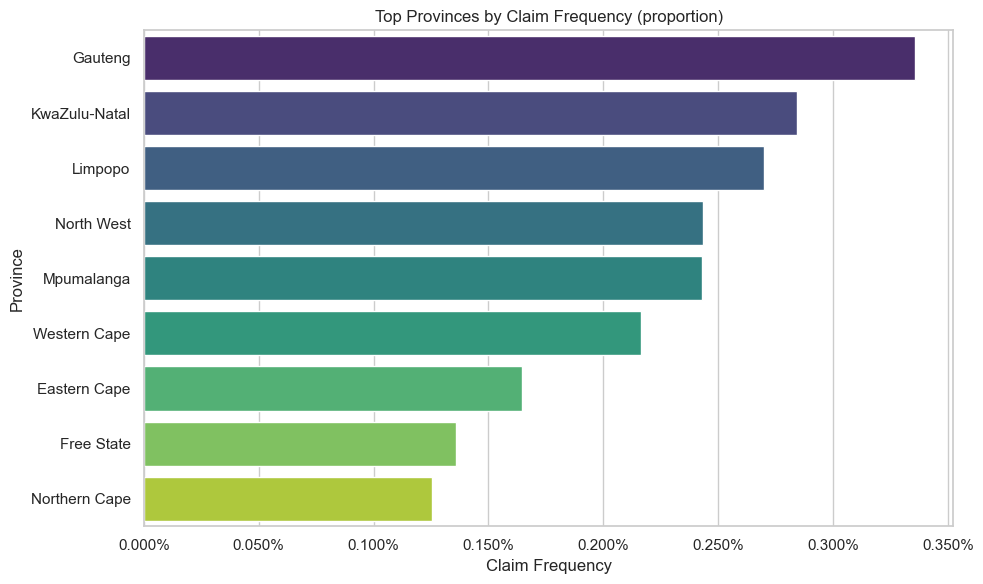

In [ ]:
# Cell 13 — Claim frequency by province
if 'Province' in df.columns:
    prov = df.groupby('Province').agg(total=('has_claim','size'), claims=('has_claim','sum')).reset_index()
    prov['claim_freq'] = prov['claims'] / prov['total']
    prov = prov.sort_values('claim_freq', ascending=False).head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(y='Province', x='claim_freq', data=prov, palette='viridis')
    plt.xlabel('Claim Frequency')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
    plt.title('Top Provinces by Claim Frequency (proportion)')
    plt.tight_layout()
    plt.show()
else:
    print("No Province column in data.")


# cell 14 - Plot 3: Outliers — boxplot of TotalClaims by VehicleType

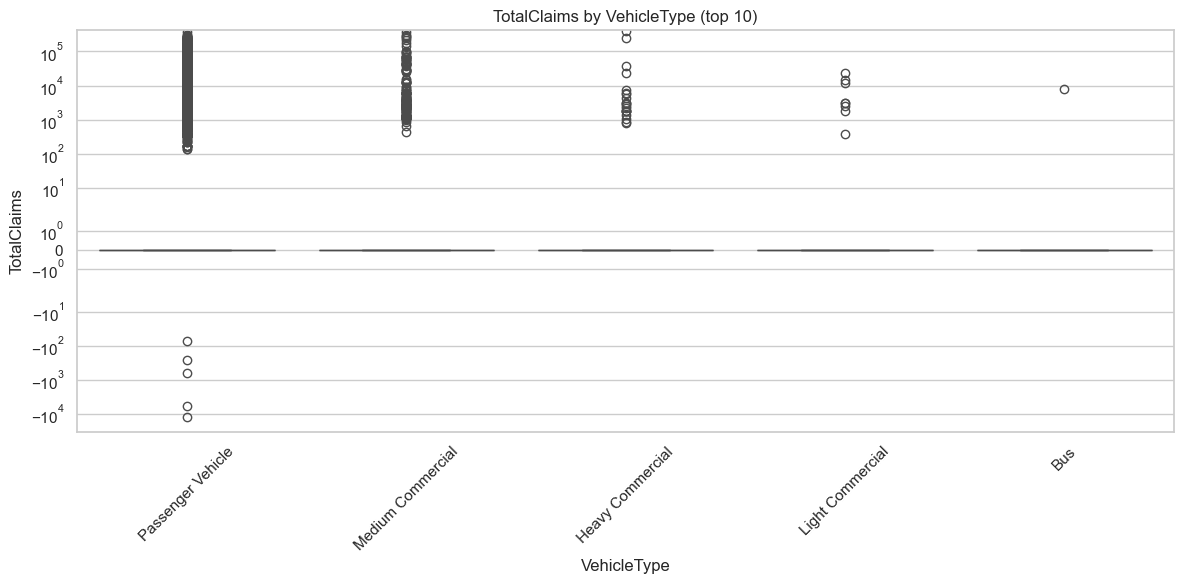

In [ ]:
# Cell 14 — Boxplot of TotalClaims by VehicleType (top categories)
if 'VehicleType' in df.columns:
    subset = df[['VehicleType','TotalClaims']].dropna()
    top_types = subset['VehicleType'].value_counts().nlargest(10).index
    subset = subset[subset['VehicleType'].isin(top_types)]
    plt.figure(figsize=(12,6))
    sns.boxplot(x='VehicleType', y='TotalClaims', data=subset)
    plt.xticks(rotation=45)
    plt.yscale('symlog')  # handles heavy skew and zeros
    plt.title('TotalClaims by VehicleType (top 10)')
    plt.tight_layout()
    plt.show()
else:
    print("No VehicleType column.")


# cell 15 - Save cleaned file (selected columns) and preview

In [15]:
# Cell 10 — Save cleaned CSV with core fields
output_cols = [
    'UnderwrittenCoverID','PolicyID','transaction_date','TotalPremium','TotalClaims',
    'has_claim','loss_ratio','margin','Province','PostalCode','Gender','VehicleType','make','Model'
]
# keep only existing cols
output_cols = [c for c in output_cols if c in df.columns]
cleaned = df[output_cols].copy()

PROCESSED_FILE.parent.mkdir(parents=True, exist_ok=True)
cleaned.to_csv(PROCESSED_FILE, index=False)
print("Saved cleaned CSV to:", PROCESSED_FILE)
display(cleaned.head(5))


Saved cleaned CSV to: ..\data\processed\insurance_cleaned.csv


,UnderwrittenCoverID,PolicyID,transaction_date,TotalPremium,TotalClaims,has_claim,loss_ratio,margin,Province,PostalCode,Gender,VehicleType,make,Model
0,145249,12827,2015-03-01,21.929825,0.0,0,0.0,21.929825,Gauteng,1459,NaN,Passenger Vehicle,MERCEDES-BENZ,E 240
1,145249,12827,2015-05-01,21.929825,0.0,0,0.0,21.929825,Gauteng,1459,NaN,Passenger Vehicle,MERCEDES-BENZ,E 240
2,145249,12827,2015-07-01,0.000000,0.0,0,NaN,0.000000,Gauteng,1459,NaN,Passenger Vehicle,MERCEDES-BENZ,E 240
3,145255,12827,2015-05-01,512.848070,0.0,0,0.0,512.848070,Gauteng,1459,NaN,Passenger Vehicle,MERCEDES-BENZ,E 240
4,145255,12827,2015-07-01,0.000000,0.0,0,NaN,0.000000,Gauteng,1459,NaN,Passenger Vehicle,MERCEDES-BENZ,E 240
